In [0]:
import tensorflow as tf
from keras.layers import Input, Dense, concatenate, BatchNormalization, Dropout, Activation
from keras.models import Model
from keras.datasets import cifar10
from keras.optimizers import Adam, SGD
from keras.regularizers import l1,l2
from keras.utils import plot_model
import cv2
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, hsv2rgb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Colorspace Conversion

In [0]:
import threading
import multiprocessing
import math

def rgb2hsl(rgb):

    def core(_rgb, _hsl):

        irgb = _rgb.astype(np.uint16)
        ir, ig, ib = irgb[:, :, 0], irgb[:, :, 1], irgb[:, :, 2]
        h, s, l = _hsl[:, :, 0], _hsl[:, :, 1], _hsl[:, :, 2]

        imin, imax = irgb.min(2), irgb.max(2)
        iadd, isub = imax + imin, imax - imin

        ltop = (iadd != 510) * (iadd > 255)
        lbot = (iadd != 0) * (ltop == False)

        l[:] = iadd.astype(np.float) / 510

        fsub = isub.astype(np.float)
        s[ltop] = fsub[ltop] / (510 - iadd[ltop])
        s[lbot] = fsub[lbot] / iadd[lbot]

        not_same = imax != imin
        is_b_max = not_same * (imax == ib)
        not_same_not_b_max = not_same * (is_b_max == False)
        is_g_max = not_same_not_b_max * (imax == ig)
        is_r_max = not_same_not_b_max * (is_g_max == False) * (imax == ir)

        h[is_r_max] = ((0. + ig[is_r_max] - ib[is_r_max]) / isub[is_r_max])
        h[is_g_max] = ((0. + ib[is_g_max] - ir[is_g_max]) / isub[is_g_max]) + 2
        h[is_b_max] = ((0. + ir[is_b_max] - ig[is_b_max]) / isub[is_b_max]) + 4
        h[h < 0] += 6
        h[:] /= 6

    hsl = np.zeros(rgb.shape, dtype=np.float)
    cpus = multiprocessing.cpu_count()
    length = int(math.ceil(float(hsl.shape[0]) / cpus))
    line = 0
    threads = []
    while line < hsl.shape[0]:
        line_next = line + length
        thread = threading.Thread(target=core, args=(rgb[line:line_next], hsl[line:line_next]))
        thread.start()
        threads.append(thread)
        line = line_next

    for thread in threads:
        thread.join()

    return hsl

def hsl2rgb(hsl):

    def core(_hsl, _frgb):

        h, s, l = _hsl[:, :, 0], _hsl[:, :, 1], _hsl[:, :, 2]
        fr, fg, fb = _frgb[:, :, 0], _frgb[:, :, 1], _frgb[:, :, 2]

        q = np.zeros(l.shape, dtype=np.float)

        lbot = l < 0.5
        q[lbot] = l[lbot] * (1 + s[lbot])

        ltop = lbot == False
        l_ltop, s_ltop = l[ltop], s[ltop]
        q[ltop] = (l_ltop + s_ltop) - (l_ltop * s_ltop)

        p = 2 * l - q
        q_sub_p = q - p

        is_s_zero = s == 0
        l_is_s_zero = l[is_s_zero]
        per_3 = 1./3
        per_6 = 1./6
        two_per_3 = 2./3

        def calc_channel(channel, t):

            t[t < 0] += 1
            t[t > 1] -= 1
            t_lt_per_6 = t < per_6
            t_lt_half = (t_lt_per_6 == False) * (t < 0.5)
            t_lt_two_per_3 = (t_lt_half == False) * (t < two_per_3)
            t_mul_6 = t * 6

            channel[:] = p.copy()
            channel[t_lt_two_per_3] = p[t_lt_two_per_3] + q_sub_p[t_lt_two_per_3] * (4 - t_mul_6[t_lt_two_per_3])
            channel[t_lt_half] = q[t_lt_half].copy()
            channel[t_lt_per_6] = p[t_lt_per_6] + q_sub_p[t_lt_per_6] * t_mul_6[t_lt_per_6]
            channel[is_s_zero] = l_is_s_zero.copy()

        calc_channel(fr, h + per_3)
        calc_channel(fg, h.copy())
        calc_channel(fb, h - per_3)

    frgb = np.zeros(hsl.shape, dtype=np.float)
    cpus = multiprocessing.cpu_count()
    length = int(math.ceil(float(hsl.shape[0]) / cpus))
    line = 0
    threads = []
    while line < hsl.shape[0]:
        line_next = line + length
        thread = threading.Thread(target=core, args=(hsl[line:line_next], frgb[line:line_next]))
        thread.start()
        threads.append(thread)
        line = line_next

    for thread in threads:
        thread.join()

    return (frgb*255).round().astype(np.uint8)

# Load and Preprocess the dataset

In [0]:
# !pip install h5py pyyaml

In [0]:
# load the dataset
(x_train, _), (x_test, _) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
xtrain_temp=[]
for i in range(x_train.shape[0]):
  xtrain_temp.append(rgb2hsl(x_train[i]))

xtest_temp=[]
for i in range(x_test.shape[0]):
  xtest_temp.append(rgb2hsl(x_test[i]))

xtrain = np.asarray(xtrain_temp)
xtest = np.asarray(xtest_temp)
xtrain = xtrain.astype('float32')
xtest = xtest.astype('float32')

# RED = hue, GREEN = luminance, BLUE = saturation
xtrain_red = xtrain[:,:,:,0] 
xtrain_green = xtrain[:,:,:,1]
xtrain_blue = xtrain[:,:,:,2] 

xtest_red = xtest[:,:,:,0]
xtest_green = xtest[:,:,:,1]
xtest_blue = xtest[:,:,:,2]

xtrain_red = xtrain_red.reshape(len(xtrain_red), np.prod(xtrain_red.shape[1:]))
xtrain_green = xtrain_green.reshape(len(xtrain_green), np.prod(xtrain_green.shape[1:]))
xtrain_blue = xtrain_blue.reshape(len(xtrain_blue), np.prod(xtrain_blue.shape[1:]))

xtest_red = xtest_red.reshape(len(xtest_red), np.prod(xtest_red.shape[1:]))
xtest_green = xtest_green.reshape(len(xtest_green), np.prod(xtest_green.shape[1:]))
xtest_blue = xtest_blue.reshape(len(xtest_blue), np.prod(xtest_blue.shape[1:]))

# Define Model

In [0]:
input_layer = xtrain_red.shape[1]
hid_layer1 = 576
hid_layer2 = 256
hid_layer3 = 64
hid_layer4 = 10
hid_layer5 = hid_layer3
hid_layer6 = hid_layer2
hid_layer7 = hid_layer1
output_layer = input_layer
print(xtrain_red.shape)
print(xtest_red.shape)

(50000, 1024)
(10000, 1024)


In [0]:
input_img_red = Input(shape=(input_layer,))
input_img_green = Input(shape=(input_layer,))
input_img_blue = Input(shape=(input_layer,))

W0817 13:47:05.504035 140051237095296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 13:47:05.550930 140051237095296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [0]:
# network architecture
# vanilla autoencoder with fully-connected layer
# RED
x = Dense(units = hid_layer1, activation='relu')(input_img_red)
# x = Dropout(rate = 0.5)(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer2, activation='relu')(x)
# x = Dropout(rate = 0.5)(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer3, activation='relu')(x)
# x = Dropout(rate = 0.5)(x)
# x = BatchNormalization()(x)

# GREEN
y = Dense(units = hid_layer1, activation='relu')(input_img_green)
# y = Dropout(rate = 0.5)(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer2, activation='relu')(y)
# y = Dropout(rate = 0.5)(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer3, activation='relu')(y)
# y = Dropout(rate = 0.5)(y)
# y = BatchNormalization()(y)

# BLUE
z = Dense(units = hid_layer1, activation='relu')(input_img_blue)
# z = Dropout(rate = 0.5)(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer2, activation='relu')(z)
# z = Dropout(rate = 0.5)(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer3, activation='relu')(z)
# z = Dropout(rate = 0.5)(z)
# z = BatchNormalization()(z)

bottleneck = concatenate([x, y, z])
encoded = Dense(units = hid_layer4, activation='relu',kernel_regularizer = l2(3e-5), activity_regularizer = l1(10e-12))(bottleneck)

# RED
x = Dense(units = hid_layer5, activation = 'relu')(encoded)
# x = Dropout(rate = 0.5)(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer6, activation='relu')(x)
# x = Dropout(rate = 0.5)(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer7, activation='relu')(x)
# x = Dropout(rate = 0.5)(x)
# x = BatchNormalization()(x)

# GREEN
y = Dense(units = hid_layer5, activation = 'relu')(encoded)
# y = Dropout(rate = 0.5)(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer6, activation='relu')(y)
# y = Dropout(rate = 0.5)(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer7, activation='relu')(y)
# y = Dropout(rate = 0.5)(y)
# y = BatchNormalization()(y)

# BLUE
z = Dense(units = hid_layer5, activation = 'relu')(encoded)
# z = Dropout(rate = 0.6)(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer6, activation='relu')(z)
# z = Dropout(rate = 0.6)(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer7, activation='relu')(z)
# z = Dropout(rate = 0.6)(z)
# z = BatchNormalization()(z)

decoded_red = Dense(units = output_layer, activation='sigmoid')(x)
decoded_green = Dense(units = output_layer, activation='sigmoid')(y)
decoded_blue = Dense(units = output_layer, activation='sigmoid')(z)

autoencoder = Model([input_img_red, input_img_green, input_img_blue], [decoded_red, decoded_green, decoded_blue])
encoder = Model([input_img_red, input_img_green, input_img_blue], encoded)

autoencoder.compile(optimizer= Adam(lr = 1e-5), loss='mean_absolute_error')

W0817 13:47:05.630804 140051237095296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 13:47:06.004740 140051237095296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
plot_model(autoencoder, to_file='model.png')

In [0]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 576)          590400      input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

# Train Model

In [0]:
# train the model
history = autoencoder.fit([xtrain_red, xtrain_green, xtrain_blue], [xtrain_red, xtrain_green, xtrain_blue],
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=([xtest_red, xtest_green, xtest_blue], [xtest_red, xtest_green, xtest_blue]))

W0817 13:47:07.186443 140051237095296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0817 13:47:07.815664 140051237095296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 19s 372us/step - loss: 0.6772 - dense_20_loss: 0.2614 - dense_21_loss: 0.2170 - dense_22_loss: 0.1982 - val_loss: 0.5710 - val_dense_20_loss: 0.2190 - val_dense_21_loss: 0.1557 - val_dense_22_loss: 0.1958
Epoch 2/100
50000/50000 [==============================] - 14s 271us/step - loss: 0.5237 - dense_20_loss: 0.1810 - dense_21_loss: 0.1482 - dense_22_loss: 0.1939 - val_loss: 0.4962 - val_dense_20_loss: 0.1668 - val_dense_21_loss: 0.1400 - val_dense_22_loss: 0.1889
Epoch 3/100
50000/50000 [==============================] - 13s 259us/step - loss: 0.4818 - dense_20_loss: 0.1636 - dense_21_loss: 0.1355 - dense_22_loss: 0.1822 - val_loss: 0.4674 - val_dense_20_loss: 0.1615 - val_dense_21_loss: 0.1314 - val_dense_22_loss: 0.1740
Epoch 4/100
50000/50000 [==============================] - 13s 270us/step - loss: 0.4578 - dense_20_loss: 0.1601 - dense_21_loss: 0.1282 - dense_22_loss: 0.16

dict_keys(['val_loss', 'val_dense_20_loss', 'val_dense_21_loss', 'val_dense_22_loss', 'loss', 'dense_20_loss', 'dense_21_loss', 'dense_22_loss'])


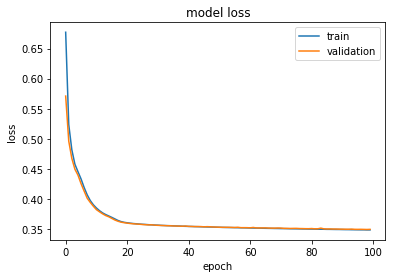

In [0]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
autoencoder.save('autoencoder_sharedLatent_hsl.h5')

# (Optional) Load Pretrained Model

In [0]:
from keras.models import load_model
autoencoder = load_model('autoencoder_sharedLatent_hsl.h5')
encoder = Model(inputs = [autoencoder.input[0], autoencoder.input[1], autoencoder.input[2]],outputs =  autoencoder.get_layer(index = 13).output)

# Reconstruction Results

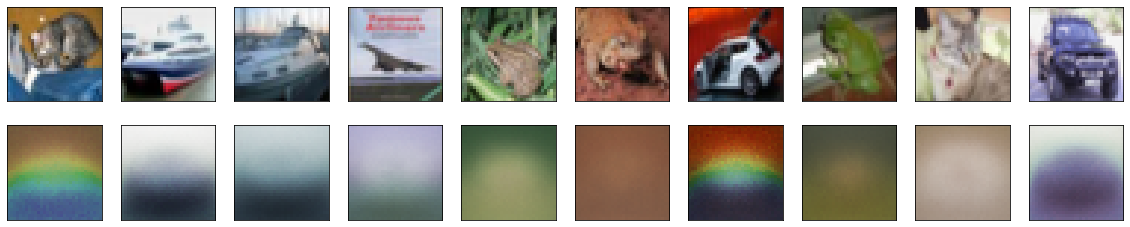

In [0]:
# show the result at the decoder output
decoded_imgs_red, decoded_imgs_green, decoded_imgs_blue = autoencoder.predict([xtest_red, xtest_green, xtest_blue])

counter = 0
n = 10
test_imgs = np.zeros((32,32,3))
dec_imgs = np.zeros((32,32,3))

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    test_imgs[:,:,0] = xtest_red[counter + i].reshape(32, 32)
    test_imgs[:,:,1] = xtest_green[counter + i].reshape(32, 32)
    test_imgs[:,:,2] = xtest_blue[counter + i].reshape(32, 32)

    plt.imshow(hsl2rgb(test_imgs))
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    dec_imgs[:,:,0] = decoded_imgs_red[counter + i].reshape(32, 32)
    dec_imgs[:,:,1] = decoded_imgs_green[counter + i].reshape(32, 32)
    dec_imgs[:,:,2] = decoded_imgs_blue[counter + i].reshape(32, 32)

    plt.imshow(hsl2rgb(dec_imgs))
    
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

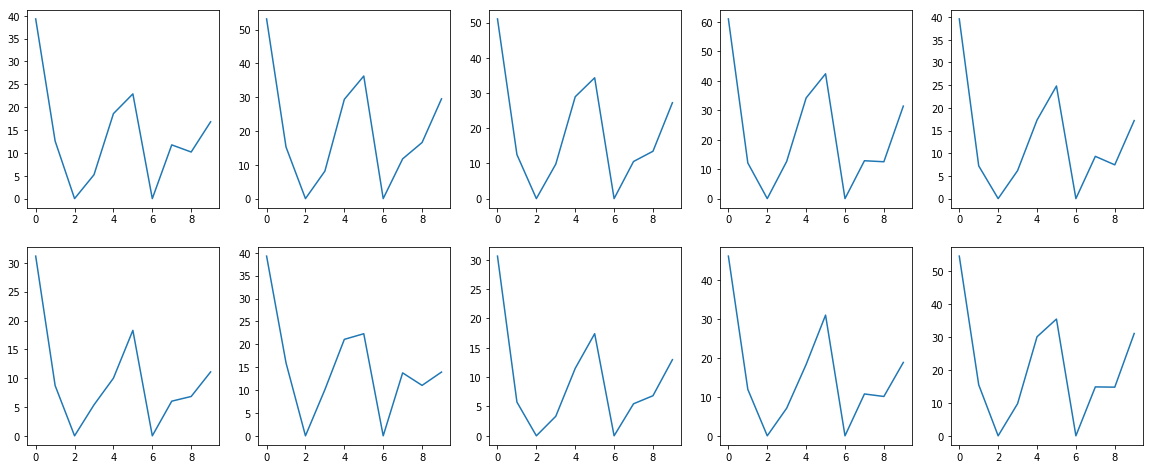

In [0]:
# show the representation at the bottleneck
encoded_imgs = encoder.predict([xtest_red, xtest_green, xtest_blue])

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, 5, i + 1)
    plt.plot(encoded_imgs[counter + i])
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

(array([702., 119.,  66.,  57.,  36.,  31.,   6.,   2.,   3.,   2.]),
 array([1.17495656e-04, 8.54618773e-02, 1.70806259e-01, 2.56150663e-01,
        3.41495037e-01, 4.26839411e-01, 5.12183785e-01, 5.97528160e-01,
        6.82872593e-01, 7.68216968e-01, 8.53561342e-01], dtype=float32),
 <a list of 10 Patch objects>)

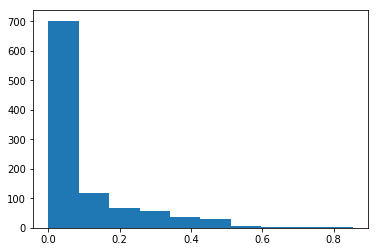

In [0]:
err_red = np.sqrt(np.square(xtest_red[0] - decoded_imgs_red[0]))
plt.hist(err_red)

(array([125., 156., 210., 254., 239.,  34.,   3.,   1.,   1.,   1.]),
 array([3.7485361e-04, 6.6281728e-02, 1.3218860e-01, 1.9809549e-01,
        2.6400235e-01, 3.2990924e-01, 3.9581612e-01, 4.6172300e-01,
        5.2762985e-01, 5.9353673e-01, 6.5944362e-01], dtype=float32),
 <a list of 10 Patch objects>)

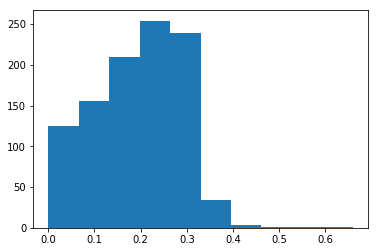

In [0]:
err_green = np.sqrt(np.square(xtest_green[0] - decoded_imgs_green[0]))
plt.hist(err_green)

(array([702., 119.,  66.,  57.,  36.,  31.,   6.,   2.,   3.,   2.]),
 array([1.17495656e-04, 8.54618773e-02, 1.70806259e-01, 2.56150663e-01,
        3.41495037e-01, 4.26839411e-01, 5.12183785e-01, 5.97528160e-01,
        6.82872593e-01, 7.68216968e-01, 8.53561342e-01], dtype=float32),
 <a list of 10 Patch objects>)

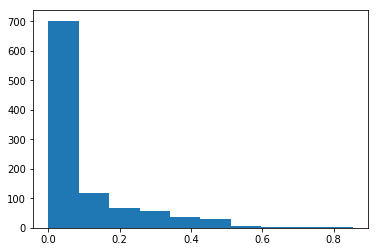

In [0]:
err_blue = np.sqrt(np.square(xtest_blue[0] - decoded_imgs_blue[0]))
plt.hist(err_red)

# Experiment: Vary the bottleneck parameters

In [0]:
def color_define(hue, saturation, luminance):
  
  if (luminance < 0.15):
    color = 'Black'
  elif (luminance > 0.9):
    color = 'White'
  else:
    if (saturation < 0.15):
      color = 'Gray'
    else:
      if  (hue >= 0 and hue < 1/12.):
        color = 'Red'
      elif (hue >= 1/12. and hue < 1/6.):
        color = 'Orange'
      elif (hue >= 1/6. and hue < 1/3.):
        color = 'Yellow'
      elif (hue >= 1/3. and hue < 1/2.):
        color = 'Green'
      elif (hue >= 1/2. and hue < 2/3.):
        color = 'Cyan'
      elif (hue >= 2/3. and hue < 5/6.):
        color = 'Blue'
      elif (hue >= 5/6. and hue < 1):
        color = 'Purple'

  return color

## 1) Extract the decoder from the model

In [0]:
from keras.models import load_model
test_model = load_model('autoencoder_sharedLatent_hsl.h5')

encoding = Input(shape = (hid_layer4,))
# RED
x = Dense(units = hid_layer5, activation = 'relu')(encoding)
# x = Dropout(rate = 0.5)(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer6, activation='relu')(x)
# x = Dropout(rate = 0.5)(x)
# x = BatchNormalization()(x)
x = Dense(units = hid_layer7, activation='relu')(x)
# x = Dropout(rate = 0.5)(x)
# x = BatchNormalization()(x)

# GREEN
y = Dense(units = hid_layer5, activation = 'relu')(encoding)
# y = Dropout(rate = 0.5)(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer6, activation='relu')(y)
# y = Dropout(rate = 0.5)(y)
# y = BatchNormalization()(y)
y = Dense(units = hid_layer7, activation='relu')(y)
# y = Dropout(rate = 0.5)(y)
# y = BatchNormalization()(y)

# BLUE
z = Dense(units = hid_layer5, activation = 'relu')(encoding)
# z = Dropout(rate = 0.6)(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer6, activation='relu')(z)
# z = Dropout(rate = 0.6)(z)
# z = BatchNormalization()(z)
z = Dense(units = hid_layer7, activation='relu')(z)
# z = Dropout(rate = 0.6)(z)
# z = BatchNormalization()(z)

decoded_red = Dense(units = output_layer, activation='sigmoid')(x)
decoded_green = Dense(units = output_layer, activation='sigmoid')(y)
decoded_blue = Dense(units = output_layer, activation='sigmoid')(z)

newModel = Model(encoding, [decoded_red, decoded_green, decoded_blue])
newModel.summary()


## 2) Assign the weights to the new decoder model

In [0]:
newModel.layers[1].set_weights(test_model.layers[14].get_weights())
newModel.layers[2].set_weights(test_model.layers[15].get_weights())
newModel.layers[3].set_weights(test_model.layers[16].get_weights())
newModel.layers[4].set_weights(test_model.layers[17].get_weights())
newModel.layers[5].set_weights(test_model.layers[18].get_weights())
newModel.layers[6].set_weights(test_model.layers[19].get_weights())
newModel.layers[7].set_weights(test_model.layers[20].get_weights())
newModel.layers[8].set_weights(test_model.layers[21].get_weights())
newModel.layers[9].set_weights(test_model.layers[22].get_weights())
newModel.layers[10].set_weights(test_model.layers[23].get_weights())
newModel.layers[11].set_weights(test_model.layers[24].get_weights())
newModel.layers[12].set_weights(test_model.layers[25].get_weights())

## 3) Vary the bottleneck nodes value

In [0]:
newbot = np.zeros(encoded_imgs.shape)

# Comment the node to switch off
newbot[:,0] = encoded_imgs[:,0] # Black
newbot[:,1] = encoded_imgs[:,1] # Green
newbot[:,2] = encoded_imgs[:,2] # Green
newbot[:,3] = encoded_imgs[:,3] # Green
newbot[:,4] = encoded_imgs[:,4] # Blue
newbot[:,5] = encoded_imgs[:,5] # Gray
newbot[:,6] = encoded_imgs[:,6] # Green
newbot[:,7] = encoded_imgs[:,7] # Green
newbot[:,8] = encoded_imgs[:,8] # Gray
newbot[:,9] = encoded_imgs[:,9] # Gray
print(newbot[0])

In [0]:
# show the result at the decoder output
decoded_imgs_red, decoded_imgs_green, decoded_imgs_blue = newModel.predict([newbot])

counter = 5
n = 1
test_imgs = np.zeros((32,32,3))
dec_imgs = np.zeros((32,32,3))

x = np.arange(1024)

plt.figure(figsize=(10, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    dec_imgs[:,:,0] = decoded_imgs_red[counter + i].reshape(32, 32)
    dec_imgs[:,:,1] = decoded_imgs_green[counter + i].reshape(32, 32)
    dec_imgs[:,:,2] = decoded_imgs_blue[counter + i].reshape(32, 32)
    
    plt.imshow(hsl2rgb(dec_imgs))

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.plot(x, decoded_imgs_red[counter + i], 'r', x, decoded_imgs_green[counter + i], 'g', x, decoded_imgs_blue[counter + i], 'b')
    plt.legend(['hue','sat','lum'], loc = 'upper right')
    plt.xlabel('pixels')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    
plt.show()

## 4) Check the color that the node represents

In [0]:
h = decoded_imgs_red[counter].mean()
s = decoded_imgs_green[counter].mean()
l = decoded_imgs_blue[counter].mean()

print(h,s,l)
color = color_define(h,s,l)      
print('color: ', color)